In [1]:
#import common modules
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from pathlib import Path

In [2]:
# import robotic fish data
data_location = Path(r'./PowerAndThrustData.xlsx')

xlsx = pd.ExcelFile(data_location, engine='openpyxl')
sheets = xlsx.sheet_names

In [3]:
roboSalmon_df = xlsx.parse(sheet_name=sheets[0])
UVTunabot_df = xlsx.parse(sheet_name=sheets[1])

In [4]:
def average_thrust(data, coeffs, case):
    St = data['Strouhal'].values
    vel = data['Velocity'].values
    freq = data['Frequency'].values

    Re = data['Re'].values

    St_wave = np.multiply(St**2, 1 - np.divide(vel, freq*coeffs['lamda']))

    if case == 'carangiform':
        xi_lamda = coeffs['beta1'] * (1 - np.exp(-coeffs['beta2'] * (coeffs['lamda-L'] - coeffs['lamda0-L'])))
    else:
        xi_lamda = coeffs['beta1'] * coeffs['lamda-L']**2 + coeffs['beta2'] * coeffs['lamda-L'] + coeffs['lamda0-L']

    CT = np.multiply(xi_lamda * (1 - (coeffs['d1']/np.sqrt(Re))), St_wave) - ((coeffs['d2']/np.sqrt(Re)) * coeffs['FB'])

    return Re, CT


In [5]:
def calc_cot(CT, density, dataframe, S_t, eff):
    return np.divide(dataframe['Electrical Power'] + ((1/eff) * CT * 0.5 * density * dataframe['Velocity']**3 * S_t), dataframe['Velocity'])  


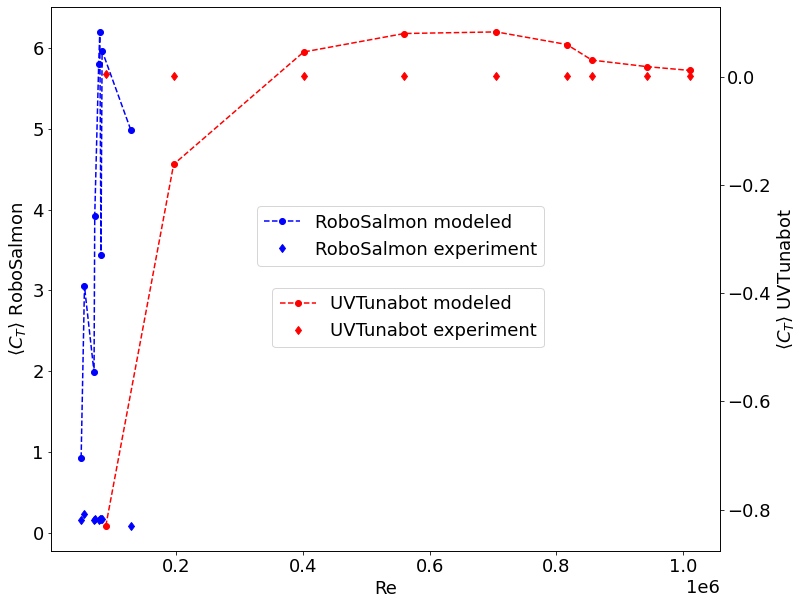

In [6]:
# define some constants for the modeling
density = 998.3
kinVisc = 1.0035e-6

case_coeffs = {}

robots = ['roboSalmon', 'UVTunabot']

L = [0.9, 0.255]
D = [0.14, 0.0492]
lam = [0.9, 0.255]
M = [4.9, 0.306]
S_t = [0.01, 0.0016]
efficiency = [0.8, 0.8]


CT = {robots[0]:{}, robots[1]:{}}
CoT = {robots[0]:{}, robots[1]:{}}

for i, frame in enumerate([roboSalmon_df, UVTunabot_df]):

    case_coeffs['carangiform'] = {'length':L[i], 'beta1':3.61, 'beta2':1.28, 'lamda0-L':0.52, 'lamda':lam[i], 'lamda-L':L[i], 'd1':11.2, 'd2':3.87, 'FB':(1 + (1.5 * (D[i]/L[i])**1.5) + (7 * (D[i]/L[i])**3)), 'xi':1.346}
    
    CT[robots[i]]['Re'], CT[robots[i]]['CT'] = average_thrust(frame, case_coeffs['carangiform'], 'carangiform')
    CT[robots[i]]['Exp'] = frame['CT'].values

    CoT[robots[i]]['modeled'] = calc_cot(CT[robots[i]]['CT'], density, frame, S_t[i], efficiency[i])
    CoT[robots[i]]['Exp'] = frame['COT']


plt.rcParams.update({'font.size':18})
fig1, ax1 = plt.subplots(figsize=(12,10), facecolor='w')
ax2 = ax1.twinx()

ax2.plot(CT['UVTunabot']['Re'], CT['UVTunabot']['CT'], 'ro--', label='UVTunabot' + ' modeled')
ax2.plot(CT['UVTunabot']['Re'], CT['UVTunabot']['Exp'], 'rd', label='UVTunabot' + ' experiment')

ax1.plot(CT['roboSalmon']['Re'], CT['roboSalmon']['CT'], 'bo--', label='RoboSalmon' + ' modeled')
ax1.plot(CT['roboSalmon']['Re'], CT['roboSalmon']['Exp'], 'bd', label='RoboSalmon' + ' experiment')

ax1.set_xlabel('Re')
ax2.set_ylabel('$\\langle C_T \\rangle $ UVTunabot')
ax1.set_ylabel('$\\langle C_T \\rangle $ RoboSalmon')
ax1.legend(bbox_to_anchor=(0.75, 0.65))
ax2.legend(bbox_to_anchor=(0.75, 0.5))

#fig1.savefig('CT_2_robots.pdf', facecolor='w', dpi=300)

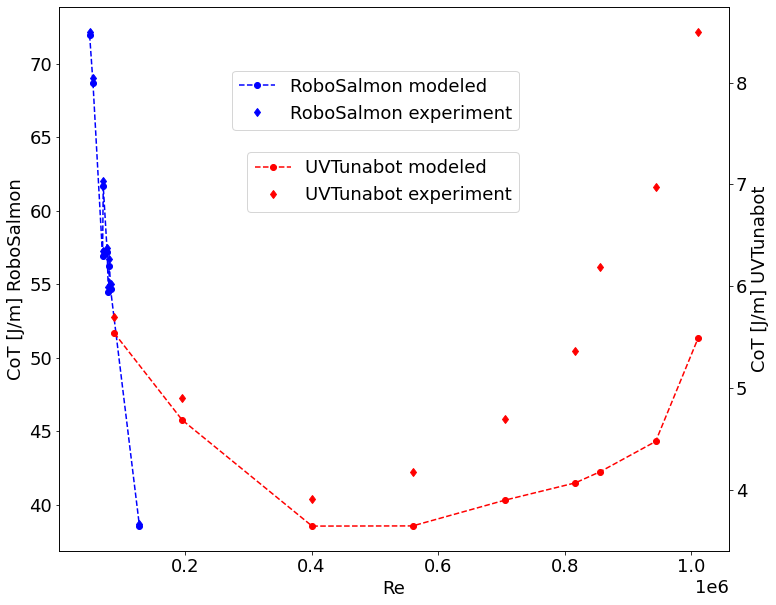

In [7]:
fig2, ax2 = plt.subplots(figsize=(12,10), facecolor='w')
ax3 = ax2.twinx()

ax3.plot(CT['UVTunabot']['Re'], CoT['UVTunabot']['modeled'], 'ro--', label='UVTunabot' + ' modeled')
ax3.plot(CT['UVTunabot']['Re'], CoT['UVTunabot']['Exp'], 'rd', label='UVTunabot' + ' experiment')

ax2.plot(CT['roboSalmon']['Re'], CoT['roboSalmon']['modeled'], 'bo--', label='RoboSalmon' + ' modeled')
ax2.plot(CT['roboSalmon']['Re'], CoT['roboSalmon']['Exp'], 'bd', label='RoboSalmon' + ' experiment')

ax2.set_xlabel('Re')
ax3.set_ylabel('CoT [J/m] UVTunabot')
ax2.set_ylabel('CoT [J/m] RoboSalmon')
ax2.legend(bbox_to_anchor=(0.7, 0.9))
ax3.legend(bbox_to_anchor=(0.7, 0.75))

#fig2.savefig('CoT_2_robots.pdf', facecolor='w', dpi=300)

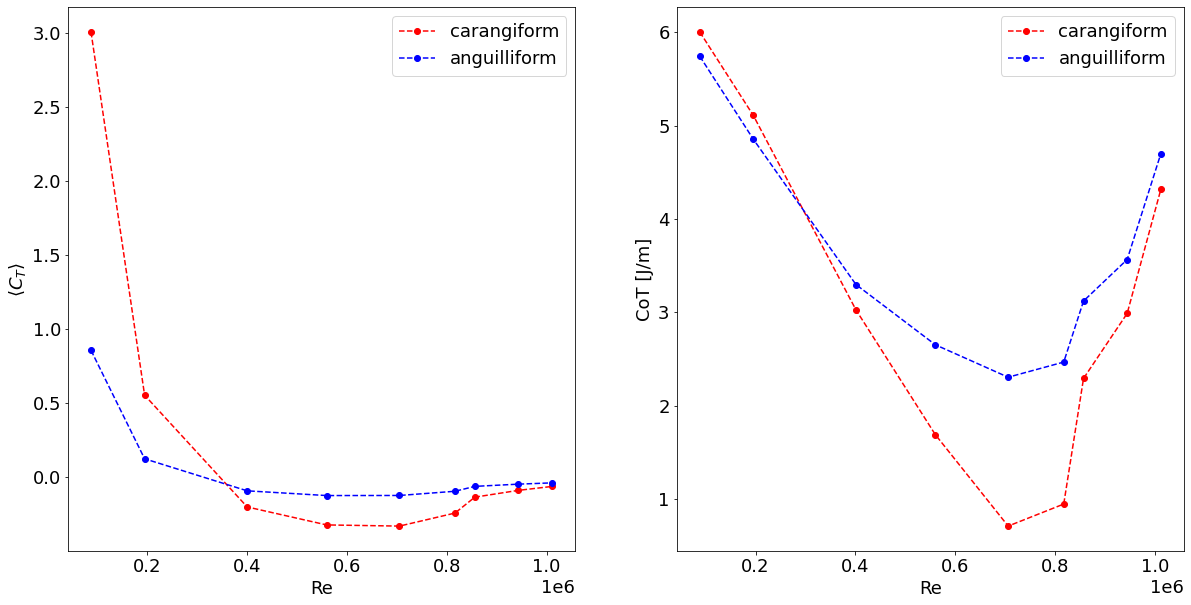

In [8]:
# define some constants for the modeling
density = 998.3
kinVisc = 1.0035e-6

case_coeffs = {}

robots = ['carangiform', 'anguilliform']

L = 0.255
D = 0.0492

SR = D/L

A = 0.1
lam = 0.255

M = 0.306
S_t = 0.0016
efficiency = 0.8

case_coeffs['carangiform'] = {'length':L, 'beta1':3.61, 'beta2':1.28, 'lamda0-L':0.52, 'lamda':lam, 'lamda-L':lam/L, 'd1':11.1, 'd2':3.87, 'FB':(1 + (1.5 * (SR)**1.5) + (7 * (SR)**3)), 'xi':1.346}
case_coeffs['anguilliform'] = {'length':L, 'beta1':3.13, 'beta2':-4.82, 'lamda0-L':3.32, 'lamda':lam, 'lamda-L':lam/L, 'd1':5.6, 'd2':3.94, 'FB':(1 + (1.5 * (2*A/lam)**1.5) + (7 * (2*A/lam)**3)), 'xi':1.463}

CT = {robots[0]:{}, robots[1]:{}}
CoT = {robots[0]:{}, robots[1]:{}}

for i, robot in enumerate(robots):

    frame = UVTunabot_df
    
    CT[robot]['Re'], CT[robot]['CT'] = average_thrust(frame, case_coeffs[robot], robot[i])
    CT[robot]['Exp'] = frame['CT'].values

    CoT[robot]['modeled'] = calc_cot(CT[robot]['CT'], density, frame, S_t, efficiency)
    CoT[robot]['Exp'] = frame['COT']

fig3, axs = plt.subplots(1, 2, figsize=(20,10), facecolor='w')
axs.flatten()

axs[0].plot(CT['carangiform']['Re'], CT['carangiform']['CT'], 'ro--', label='carangiform')
axs[0].plot(CT['anguilliform']['Re'], CT['anguilliform']['CT'], 'bo--', label='anguilliform')

axs[1].plot(CT['carangiform']['Re'], CoT['carangiform']['modeled'], 'ro--', label='carangiform')
axs[1].plot(CT['anguilliform']['Re'], CoT['anguilliform']['modeled'], 'bo--', label='anguilliform')


axs[0].set_xlabel('Re')
axs[0].set_ylabel('$ \\langle C_T \\rangle $')
axs[0].legend()

axs[1].set_xlabel('Re')
axs[1].set_ylabel('CoT [J/m]')
axs[1].legend()

#fig3.savefig('CoT_2_modes.pdf', facecolor='w', dpi=300)

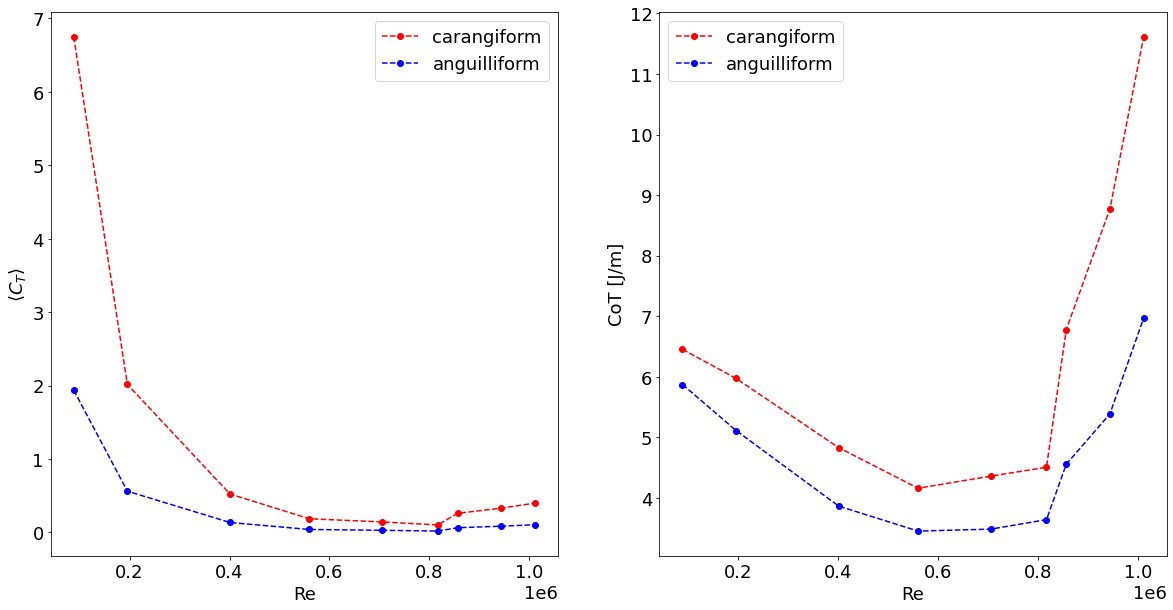

In [18]:
robots = ['carangiform', 'anguilliform']

L = 0.255
D = 0.0492

SR = D/L

lam = 0.35
A = 0.1

M = 0.306
S_t = 0.0016
efficiency = 0.8

case_coeffs['carangiform'] = {'length':L, 'beta1':3.61, 'beta2':1.28, 'lamda0-L':0.52, 'lamda':lam, 'lamda-L':lam/L, 'd1':11.1, 'd2':3.87, 'FB':(1 + (1.5 * (SR)**1.5) + (7 * (SR)**3)), 'xi':1.346}
case_coeffs['anguilliform'] = {'length':L, 'beta1':3.13, 'beta2':-4.82, 'lamda0-L':3.32, 'lamda':lam, 'lamda-L':lam/L, 'd1':5.6, 'd2':3.94, 'FB':(1 + (1.5 * (2*A/lam)**1.5) + (7 * (2*A/lam)**3)), 'xi':1.463}

CT = {robots[0]:{}, robots[1]:{}}
CoT = {robots[0]:{}, robots[1]:{}}

for i, robot in enumerate(robots):

    frame = UVTunabot_df
    
    CT[robot]['Re'], CT[robot]['CT'] = average_thrust(frame, case_coeffs[robot], robot[i])
    CT[robot]['Exp'] = frame['CT'].values

    CoT[robot]['modeled'] = calc_cot(CT[robot]['CT'], density, frame, S_t, efficiency)
    CoT[robot]['Exp'] = frame['COT']


fig4, axs = plt.subplots(1, 2, figsize=(20,10), facecolor='w')
axs.flatten()

axs[0].plot(CT['carangiform']['Re'], CT['carangiform']['CT'], 'ro--', label='carangiform')
axs[0].plot(CT['anguilliform']['Re'], CT['anguilliform']['CT'], 'bo--', label='anguilliform')

axs[1].plot(CT['carangiform']['Re'], CoT['carangiform']['modeled'], 'ro--', label='carangiform')
axs[1].plot(CT['anguilliform']['Re'], CoT['anguilliform']['modeled'], 'bo--', label='anguilliform')

axs[0].set_xlabel('Re')
axs[0].set_ylabel('$ \\langle C_T \\rangle $')
axs[0].legend()

axs[1].set_xlabel('Re')
axs[1].set_ylabel('CoT [J/m]')
axs[1].legend()